In [11]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

In [7]:
## set gpu
gpu = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu}" 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# Load model

In [8]:
model_dir ='/media/SSD/rheology2023/EffNetB7Model/Regression/Blood_Viscosity/HN-NBL_classes/fold1/R1/models/EffNetB7_HN-NBL_Class_fold1_R1.h5' #แก้
model = load_model(model_dir)
height = width = model.input_shape[1]

2023-09-26 12:03:19.230502: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-09-26 12:03:19.231101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-09-26 12:03:19.231153: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-09-26 12:03:19.231175: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-09-26 12:03:19.231182: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-09-26 12:03:19.231190: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft

In [9]:
print(height, width)

600 600


## Select Data

In [13]:
df_2dFFT = pd.read_csv("/home/kannika/codes_AI/Rheology_Blood/Dataset_Rheology_Blood_Viscosity_HN_NBL-2dFFTdataset-3channels-6Fold.csv")
train_2dFFT = df_2dFFT[df_2dFFT['fold']!=1].reset_index(drop=True)
print("Train set", set(train_2dFFT['fold']))
print(train_2dFFT.shape)

test_2dFFT = df_2dFFT[df_2dFFT['fold']==1].reset_index(drop=True)
print("Test set", set(test_2dFFT['fold']))
print(test_2dFFT.shape)

test_2dFFT.head()

Train set {2, 3, 4, 5, 6}
(446, 12)
Test set {1}
(92, 12)


,Unnamed: 0,Unnamed: 0.1,image_name,image_path,image_folder,folder_source,classes,Code,subclass,fold,dt,classes_binary
0,30,30,HN12_D0_30HZ_20XINF_UWELL_25651122_135932_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_135932,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1
1,31,31,HN12_D0_30HZ_20XINF_UWELL_25651122_140145_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_140145,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1
2,32,32,HN12_D0_30HZ_20XINF_UWELL_25651122_140431_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_140431,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1
3,33,33,HN12_D0_30HZ_20XINF_UWELL_25651122_140721_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_140721,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1
4,34,34,HN12_D0_30HZ_20XINF_UWELL_25651122_141024_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_141024,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (height, width)
BATCH_SIZE = 16

### Get data Loder
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range=20,
                    brightness_range=[0.5, 1.5],
                    shear_range=0.5,
                    horizontal_flip = False,
                    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_2dFFT,
        directory = None,
        x_col = 'image_path',
        y_col = 'classes',
        target_size = (height, width),
        batch_size=BATCH_SIZE,
        color_mode= 'rgb',
        class_mode='categorical')


#label
labels = (train_generator.class_indices)
labels = dict((v,k.replace("C","")) for k,v in labels.items())
print(labels)

Found 446 validated image filenames belonging to 2 classes.
{0: 'HN', 1: 'NBL'}


## Prediction

In [19]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

In [20]:
#Predict
pred_list = list()
prob_list = list()
img_path=test_2dFFT['image_path'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

2023-09-26 12:15:37.161220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-26 12:15:37.180737: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz
2023-09-26 12:15:39.879076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-09-26 12:15:40.233522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-09-26 12:15:40.240226: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2023-09-26 12:15:41.374449: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-09-26 12:15:41.476516: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform 

In [24]:
predict

array([0.6193466 , 0.38065335], dtype=float32)

In [23]:
print(len(pred_list))
print(len(prob_list))

test_2dFFT['category'] = pred_list
test_2dFFT['Prob'] = prob_list
test_2dFFT.head()

92
92


,Unnamed: 0,Unnamed: 0.1,image_name,image_path,image_folder,folder_source,classes,Code,subclass,fold,dt,classes_binary,category,Prob
0,30,30,HN12_D0_30HZ_20XINF_UWELL_25651122_135932_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_135932,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1,HN,0.616190
1,31,31,HN12_D0_30HZ_20XINF_UWELL_25651122_140145_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_140145,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1,HN,0.616163
2,32,32,HN12_D0_30HZ_20XINF_UWELL_25651122_140431_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_140431,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1,HN,0.621684
3,33,33,HN12_D0_30HZ_20XINF_UWELL_25651122_140721_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_140721,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1,HN,0.623521
4,34,34,HN12_D0_30HZ_20XINF_UWELL_25651122_141024_dt2_...,/media/HDD/rheology2023/Blood_Viscosity_2dFFT/...,HN12_D0_30HZ_20XINF_UWELL_25651122_141024,SSD_Backup,HN,HN12,Splenectomy,1,"[2, 5, 7]",1,HN,0.619231


In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = test_2dFFT['classes'].array
pred = test_2dFFT['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 65.21739130434783%
              precision    recall  f1-score   support

          HN       0.65      1.00      0.79        60
         NBL       0.00      0.00      0.00        32

    accuracy                           0.65        92
   macro avg       0.33      0.50      0.39        92
weighted avg       0.43      0.65      0.51        92



/home/kannika/miniconda3/envs/tf24EffNetV2py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kannika/miniconda3/envs/tf24EffNetV2py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kannika/miniconda3/envs/tf24EffNetV2py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### Confusion matrix

Text(0.5, 21.249999999999993, 'Predicted label')

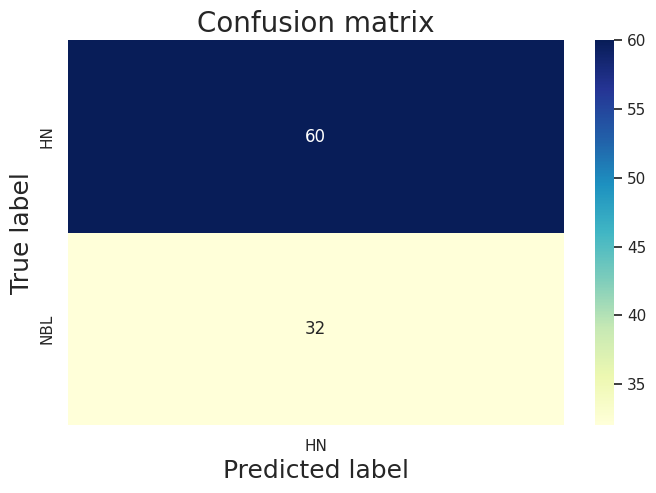

In [28]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)